### COVID-19 Chest X-Ray Image Recognition Initial Model 

This project is influenced by Thomas Mann's *The Magic Mountain*, in which protagonist Hans Castorp spends seven years at a sanatorium that treats tuberculosis patients in the early part of the 20th century. Mann describes the chest x-ray images of patients in great detail, with Dr. Behrens explaining to Hans Castorp which telltale signs in the images indicate tuberculosis.

While tuberculosis is still a significant ailment in many parts of the world, this project is concerned with a more topical disease - COVID-19. While there are several tests available to test for COVID-19, x-ray imaging still plays a vital role in understanding the damage that COVID can wreak on a patient's lungs.

COVID can cause patients to develop pneumonia. There is a great deal of research being done to determine how COVID based pnuemonia differs from non-COVID pnuemonia. While COVID and non-COVID pneumonias are both viral, there are some distinguishing features of the COVID variety, including a ground glass appearance on CT scans and that it affects both lungs rather than just one (though non-COVID pneumonias can also effect both lungs).

This project will attempt to train a model to distinuish among the lungs of COVID, viral (non-COVID) pneumonia, and healthy patients (or at least those that don't have either type of pneumonia).

We'll be working with over 3800 images collected from a variety of sources, all of which can be found here: https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

For this particular notebook, we'll only be creating an inital model. In a subsequent notebook, we'll test several pretrained models, such as ResNet50 and DenseNet169, and tune the strongest inital model to achieve the highest accuracy possible.




Let's begin by loading any libraries we may need, including tensorflow, keras, pandas, numpy, and matplotlib.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

Add a couple of random seeds to make our outcomes more consistent.

In [3]:
# Random seeds from both numpy and tensorflow
from numpy.random import seed
seed(99)
tf.random.set_seed(99)    # for tensorflow 2.0 and above

Since this is being done on Colab, we'll mount the images from Google Drive. There are other ways to also load the images, depending on which application you're using.

In [4]:
# Mount Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The following sets of images are chest x-rays of COVID patients, followed by pneumonia and healthy (labeled as NORMAL) patients.

Display random COVID patient images


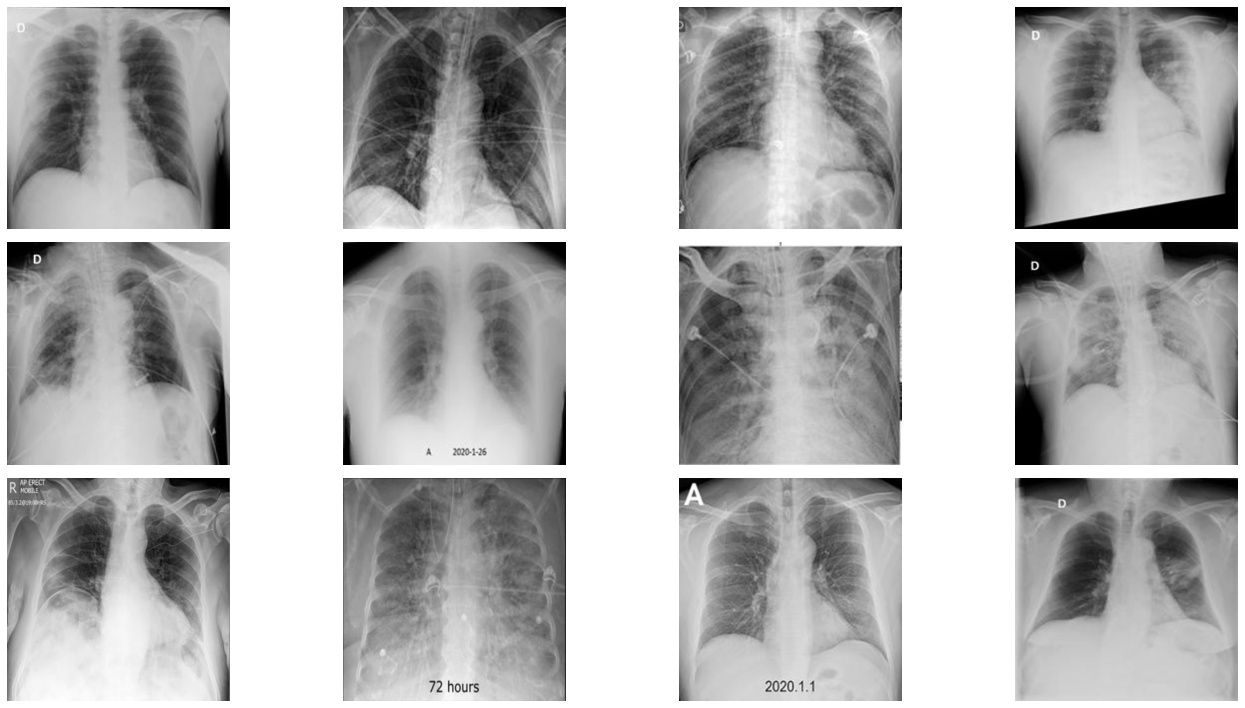

In [5]:
# Location of images
path = "/content/drive/MyDrive/COVID-19 Radiography Database/train/COVID"
image_files = os.listdir(path)


print('Display random COVID patient images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

# Select and display random images
for i in range(12):
    plt.subplot(3, 4, i + 1)
    img = plt.imread(os.path.join(path, image_files[random.randrange(0, len(image_files))]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()

Display random viral pneumonia patient images


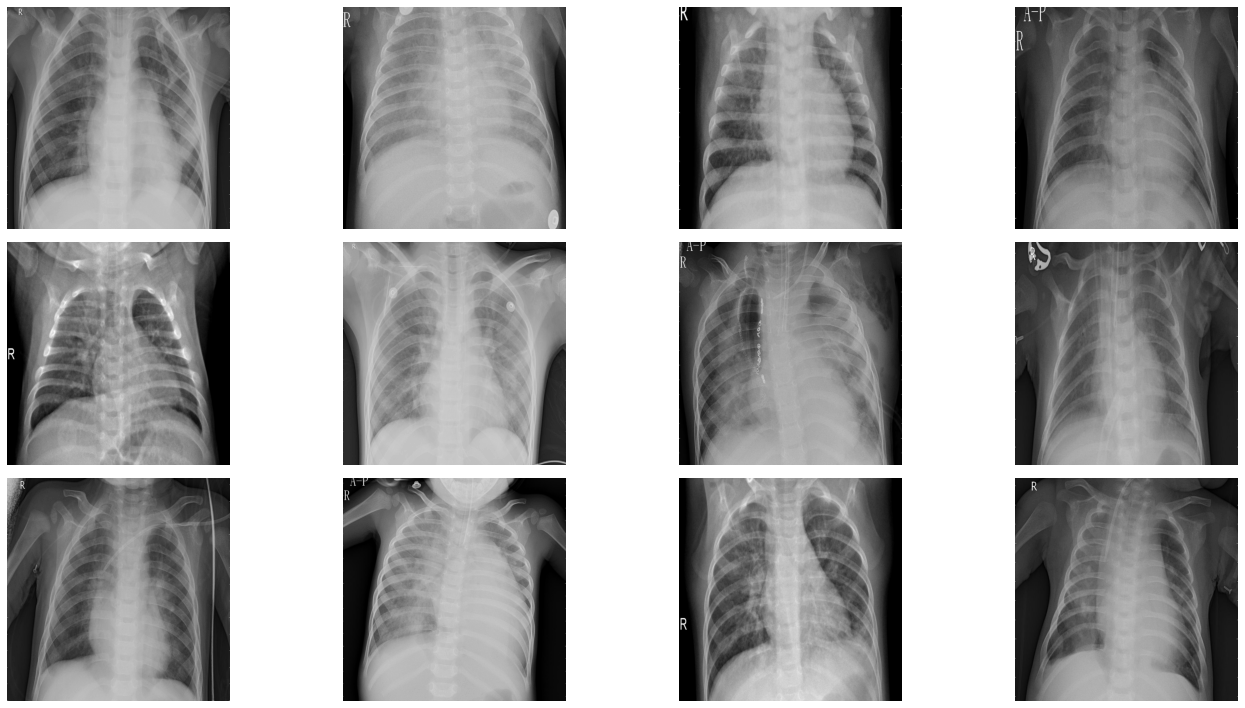

In [6]:
# Location of images
path = "/content/drive/MyDrive/COVID-19 Radiography Database/train/Viral Pneumonia"
image_files = os.listdir(path)


print('Display random viral pneumonia patient images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

# Select and display random images
for i in range(12):
    plt.subplot(3, 4, i + 1)
    img = plt.imread(os.path.join(path, image_files[random.randrange(0, len(image_files))]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()

Display random normal patient images


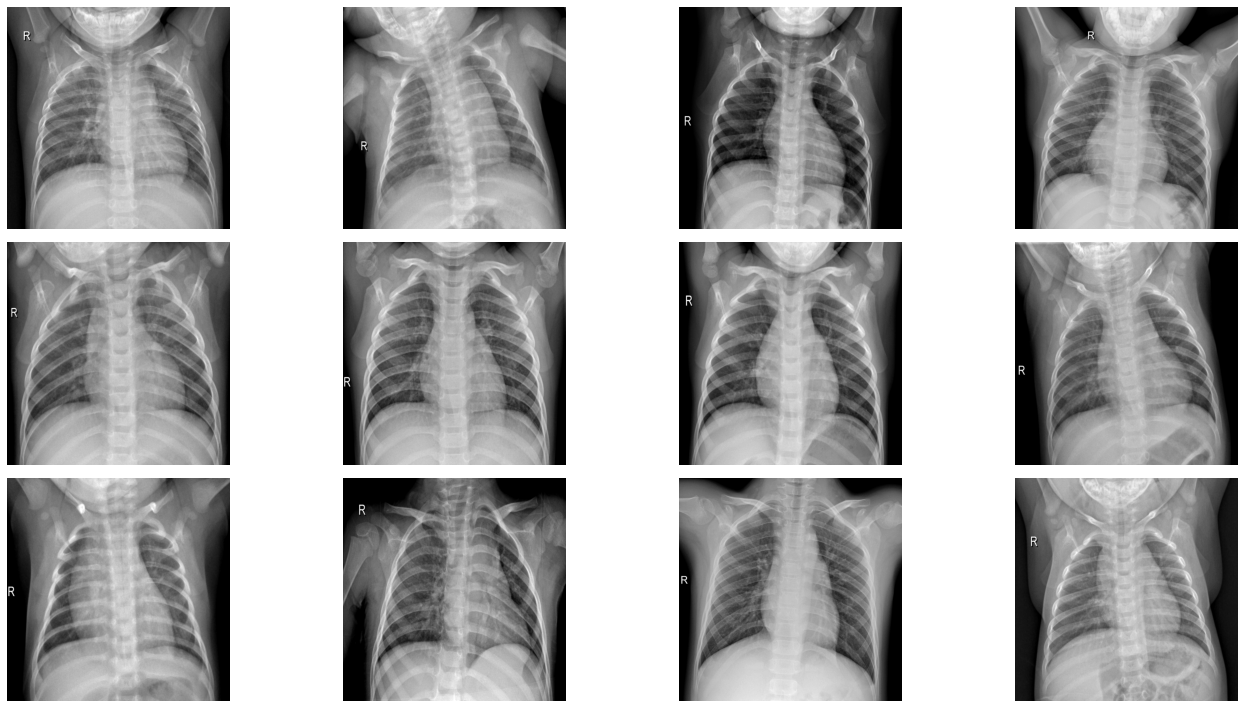

In [7]:
# Location of images
path = "/content/drive/MyDrive/COVID-19 Radiography Database/train/NORMAL"
image_files = os.listdir(path)


print('Display random normal patient images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

# Select and display random images
for i in range(12):
    plt.subplot(3, 4, i + 1)
    img = plt.imread(os.path.join(path, image_files[random.randrange(0, len(image_files))]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()

As we can see, there are some similarities between the COVID and pneumonia patients, particularly with regard to the cloudy appearance of the scans. However, the COVID patients on average seem to have the cloudiest images, while the healthy patients have the clearest. 

In [8]:
# Import ImageDataGenerator to allow us to create batches and perform data augmentation
from keras.preprocessing.image import ImageDataGenerator

For now, we won't perform data augmentation, but that will likely change once we are fine tuning our best performing models.

In [9]:
# Rescale the images
train_data_generator = ImageDataGenerator(rescale=1./255)
valid_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [10]:
# Paths to access the correct image folders
train_path = '/content/drive/MyDrive/COVID-19 Radiography Database/train'
valid_path = '/content/drive/MyDrive/COVID-19 Radiography Database/validation'
test_path = '/content/drive/MyDrive/COVID-19 Radiography Database/test'

We'll now use image generator to define where our train, validation, and test images are found as well as to dictate image size and batch size. The orignal images size is 256 x 256, but we'll keep our image size relatively small to speed up learning. We're running a 60/20/20 split.  

In [11]:
train_batches = train_data_generator.flow_from_directory(train_path, 
                                                                   target_size=(128, 128), 
                                                                   classes=['COVID', 'NORMAL', 'Viral Pneumonia'], 
                                                                   batch_size=32)
valid_batches = valid_data_generator.flow_from_directory(valid_path, 
                                                        target_size=(128, 128), 
                                                        classes=['COVID', 'NORMAL', 'Viral Pneumonia'], 
                                                        batch_size=32)

test_batches = test_data_generator.flow_from_directory(test_path, 
                                                        target_size=(128, 128), 
                                                        classes=['COVID', 'NORMAL', 'Viral Pneumonia'], 
                                                        batch_size=32)

Found 2335 images belonging to 3 classes.
Found 776 images belonging to 3 classes.
Found 775 images belonging to 3 classes.


We'll create a very basic model, with 3 convolutional and pooling layers as well as a flattening layer and two dense layers. We'll also use relu and softmax activations. It's difficult to know ahead of time how to shape an initial model, including the number of layers it should have. This partcular model was recommended by a friend (Thanks, Antony!), so it's as good as any for an inital run.  

In [21]:
model = keras.Sequential([
    # Block 1
    layers.Conv2D(16, (3,3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(),
    
    # Block 2
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    # Block 3
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    # Fully-connected NN
    layers.Flatten(), 
    layers.Dense(512, activation='relu'), 
    layers.Dense(3, activation='softmax')  
])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 63, 63, 16)        64        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)       

Since we're dealing with a mutliclassification problem, we'll use categorical crossentropy for our loss and an adam optimizer. 

In [23]:
# Complile the model
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics = ['accuracy'])

In [24]:
# fit/train the model using the images and labels
%%time

history = model.fit(
      train_batches,
      steps_per_epoch=73,
    
      epochs=15,
    
      # validate the trained model on unseen (validation) images
      validation_data = valid_batches,
      validation_steps=25,
      verbose=1)

Epoch 1/15
73/73 [==============================] - 42s 573ms/step - loss: 1.5950 - accuracy: 0.8325 - val_loss: 0.9278 - val_accuracy: 0.5026
Epoch 2/15
73/73 [==============================] - 41s 562ms/step - loss: 0.1726 - accuracy: 0.9435 - val_loss: 1.1485 - val_accuracy: 0.6366
Epoch 3/15
73/73 [==============================] - 41s 561ms/step - loss: 0.0782 - accuracy: 0.9722 - val_loss: 0.4341 - val_accuracy: 0.7964
Epoch 4/15
73/73 [==============================] - 41s 562ms/step - loss: 0.0571 - accuracy: 0.9790 - val_loss: 0.7233 - val_accuracy: 0.7307
Epoch 5/15
73/73 [==============================] - 41s 559ms/step - loss: 0.0567 - accuracy: 0.9820 - val_loss: 0.6686 - val_accuracy: 0.7912
Epoch 6/15
73/73 [==============================] - 40s 547ms/step - loss: 0.0382 - accuracy: 0.9867 - val_loss: 0.3141 - val_accuracy: 0.8995
Epoch 7/15
73/73 [==============================] - 40s 554ms/step - loss: 0.0313 - accuracy: 0.9880 - val_loss: 0.3576 - val_accuracy: 0.9085

After training the model for just 15 epochs, we see a fairly high amount of accuracy for both the training and validation sets. There is some amount of overfitting as we can see more clearly in the graphs below. 

In [25]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.figure(figsize=(15, 7))
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.title('Training and validation')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

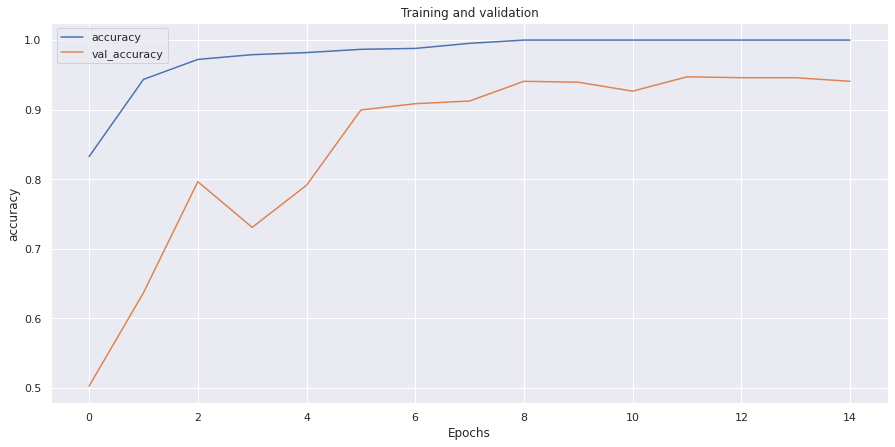

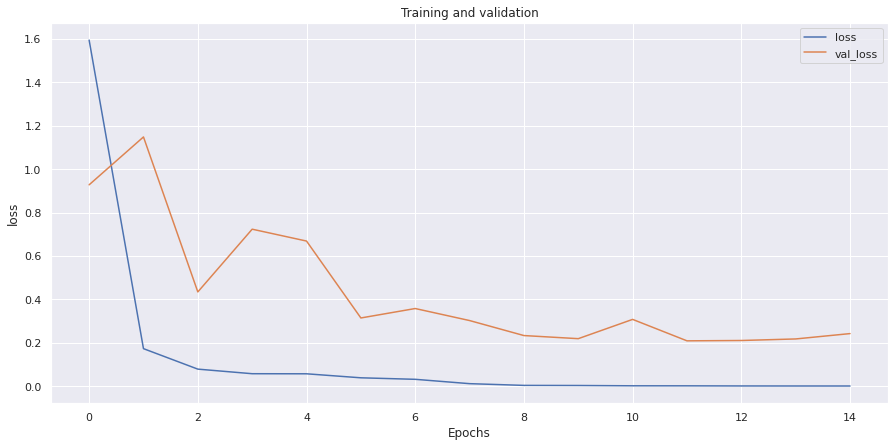

In [26]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [27]:
# Save the model
model.save("initial_model")

INFO:tensorflow:Assets written to: initial_model/assets


In [28]:
# restore the model and do some test set evaluation.
from tensorflow.keras.models import load_model
initial_model = load_model('initial_model')

Running the model on the test set, we again see some overfitting. We may need to find a way to speed it up without sacrificing accuracy. However, achieving accuracy over 90% for a basic model is a great start.  

In [29]:
# Running the model on the test set
test_loss, test_acc = initial_model.evaluate(test_batches, steps=25)
print('test loss:', test_loss)
print('test acc:', test_acc)

25/25 [==============================] - 12s 454ms/step - loss: 0.2295 - accuracy: 0.9484
test loss: 0.22948294878005981
test acc: 0.948387086391449


In the next part of the project, we'll see if we can achieve even higher accuracy by testing pretrained models on the same dataset. We'll tune whichever model is the most successful in an attempt to get as close as possible to 100% accuracy. 

If this does end up being our final model, there are many techniques we can still apply - adding or subtracting layers (inlcuding Dropout), using callbacks such as ModelCheckpoint, increasing the number of epochs, and finding an ideal learning rate, 